In [76]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,6.0)     #default size
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#训练样本
file = './data/train/*.jpg'
coll = io.ImageCollection(file)
X_train = np.asarray(coll)
y_train = np.hstack((np.zeros(250),np.ones(250)))
y_train = y_train.reshape((1,500))

#测试样本
file = './data/test/*.jpg'
coll = io.ImageCollection(file)
X_test = np.asarray(coll)
y_test = np.hstack((np.zeros(100),np.ones(100)))
y_test = y_test.reshape((1,200))

m_train = X_train.shape[0]
m_test = X_test.shape[0]
w,h,d = X_train.shape[1],X_train.shape[2],X_train.shape[3]

print('训练样本数量：%d' % m_train)
print('测试样本数量：%d' % m_test)
print('每张图片的维度：(%d, %d, %d)' % (w, h, d))


训练样本数量：500
测试样本数量：200
每张图片的维度：(64, 64, 3)


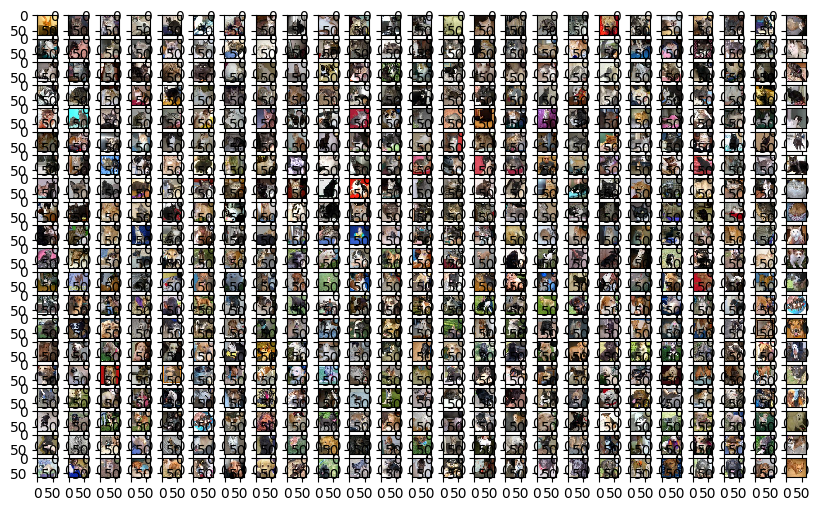

In [77]:

for i in range(500):
    plt.subplot(20,25,i+1)
    plt.imshow(X_train[i])

plt.show()

In [78]:
'''X_train和X_test的预处理，方便运算'''
X_train = X_train.reshape(m_train,-1).T #-1 表示自由伸展
X_test = X_test.reshape(m_test,-1).T
print(X_train.shape)
print(X_test.shape)

(12288, 500)
(12288, 200)


### 网格输入标准化
有 m个训练样本，特征维度是 n，那么对于 n 个特征，计算其均值向量 $\mu$ 和标准差向量 $\sigma$：

$$\mu=\frac1m\sum_{i=1}^mX^{(i)}$$

$$\sigma=\sqrt{\frac{1}{m-1}\sum_{i=1}^m(X^{(i)}-u)^2}$$

$$X'=\frac{X-u}{\sigma}$$

其中，$X$ 的维度为 (m, n) 

In [79]:
# 先计算均值和标准差

mean_image = np.mean(X_train,axis = 1)
std_image = np.std(X_train,axis = 1)

# 标准化
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_train -= mean_image.reshape(12288, 1)
X_train /= std_image.reshape(12288, 1)
X_test -= mean_image.reshape(12288, 1)
X_test /= std_image.reshape(12288, 1)

### 划分mini-batch
有利于提高神经网络的训练速度
mini-batch ： 将训练集划分为 n 个mini训练集，每个mini训练集包含64、128或者256个元素

In [80]:
'''划分mini-batch'''

def random_mini_batch(X,Y,mini_batch_size = 64):
    m = X.shape[1]
    mini_batches = []

    permutation = list(np.random.permutation(m))    #输出一个包含 0-m 每个数的list 并且打乱顺序
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation].reshape((1,m))
    
    #floor的作用是返回小于此参数的最大整数，目的先分配完前面能够组成64个mini-batch的,最后没达到64个元素的集合也能作为一个mini训练集
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)

    #多出来的被mini-batch_size除不尽的一些样本重新组成一个新的mini-batch
    if m % mini_batch_size != 0 :
        mini_batch_X = shuffled_X[:,mini_batch_size*math.floor(m/mini_batch_size):m]
        mini_batch_Y = shuffled_Y[:,mini_batch_size*math.floor(m/mini_batch_size):m]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches
# random_mini_batch(X_train,y_train,64)

In [81]:
'''初始化 w 和 b'''

def initialize_parameters(layers_dims):

    parameters = {}
    L = len(layers_dims) - 1 #网络层数

    for l in range(1,L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters['b'+str(l)] = np.zeros((layers_dims[l],1))

    return parameters

In [82]:
'''损失函数'''
# 输入第 L 层输出和 真实值
def compute_cost(AL,Y):
    
    m = AL.shape[1]     #m 为样本个数，1行 m 个
    cost = -1/m * np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))

    cost = np.squeeze(cost)     # 压缩维度，减少[]

    return cost

神经网络 L2 正则化是指在损失函数中增加 $||w||^2$ 项，表达式如下：

$$J(w^{[1]},b^{[1]},\cdots,w^{[L]},b^{[L]})=\frac1m\sum_{i=1}^mL(\hat
y^{(i)},y^{(i)})+\frac{\lambda}{2m}\sum_{l=1}^L||w^{[l]}||^2$$

$$||w^{[l]}||^2=\sum_{i=1}^{n^{[l]}}\sum_{j=1}^{n^{[l-1]}}(w_{ij}^{[l]})^2$$

其中，$l$ 表示当前神经网络层数，$n^{[l]}$ 为当前神经网络层包含的神经元个数。

因此，我们要在原来的损失函数 Loss 基础上加上 L2 正则项。

In [83]:
'''计算损失函数 L2 正则化'''
def compute_cost_with_regularization(A3,Y,parameters,lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    cross_entropy_cost = compute_cost(A3,Y)    #损失函数交叉熵

    L2_regularization_cost = lambd/(2*m)*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))    #正则化

    cost = cross_entropy_cost + L2_regularization_cost

    return cost

In [84]:
'''L2正则化的反向传播'''
def backward_propagation_with_regularization(X,Y,cache,lambd):
    m = X.shape[1]
    (Z1,A1,W1,b1,Z2,A2,W2,b2,Z3,A3,W3,b3) = cache

    dZ3 = A3 - Y

    dW3 = 1./m * np.dot(dZ3,A2.T)+lambd/m*W3
    db3 = 1./m * np.sum(dZ3,axis=1,keepdims=True)

    dA2 = np.dot(W3.T,dZ3)
    dZ2 = np.multiply(dA2,np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2,A1.T)+lambd/m*W2
    db2 = 1./m * np.sum(dZ2,axis = 1,keepdims=True)

    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1,X.T)+lambd/m*W1
    db1 = 1./m * np.sum(dZ1,axis = 1,keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

### Dropout正则化
丢弃20% 保留80%
但是需要在丢弃之后进行scale Up处理，乘以1/0.8

In [85]:
'''正向传播（前向运算）单层神经元'''
# sigmoid 函数
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

# reLu 函数
def reLu(Z):
    A = np.maximum(0,Z)
    return A

# 单个神经元运算单元
def linear_activation_forward(A_prev,W,b,activation):

    Z = np.dot(W,A_prev) + b  #线性输出
    if activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'reLu':
        A = reLu(Z)
    
    cache = (A_prev,W,b,Z)

    return A,cache    

In [86]:
'''正向传播（前向运算） L层神经元
   前 l-1 层用reLu函数，最后一层用sigmoid函数
'''
def forward_propagation(X,parameters):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1,X) + b1
    A1 = reLu(Z1)

    Z2 = np.dot(W2,A1) + b2
    A2 = reLu(Z2)

    Z3 = np.dot(W3,A2) + b3
    A3 = sigmoid(Z3)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return A3,cache

In [87]:
'''Dropout正则化'''
def forward_propagation_with_dropout(X,parameters,keep_prob = 0.8):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1,X) + b1
    A1 = reLu(Z1)

    D1 = np.random.rand(A1.shape[0],A1.shape[1])    # step1 : 初始化掩膜矩阵 "这里rand正好是返回 0 - 1 之间的值
    D1 = D1 < keep_prob                             # step2 : D1 阈值比较 0 or 1
    A1 = A1 * D1                                    # step3 : 关闭一些神经元
    A1 = A1 / keep_prob                             # step4 : scale up 保持期望值一致

    Z2 = np.dot(W2,A1) + b2
    A2 = reLu(Z2)

    D2 = np.random.rand(A2.shape[0],A2.shape[1])    # step1 : 初始化掩膜矩阵 "这里rand正好是返回 0 - 1 之间的值
    D2 = D2 < keep_prob                             # step2 : D1 阈值比较 0 or 1
    A2 = A2 * D2                                    # step3 : 关闭一些神经元
    A2 = A2 / keep_prob                             # step4 : scale up 保持期望值一致

    Z3 = np.dot(W3,A2) + b3
    A3 = sigmoid(Z3)

    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)

    return A3,cache

In [88]:
'''反向传播，减少损失函数'''
# reLu求倒数
'''这里 第Z层的reLu'''
def reLu_backward(dA,Z):
    dZ = np.array(dA,copy=True)
    dZ[Z <= 0] = 0
    
    return dZ

# sigmoid求导数
def sigmoid_backward(dA,Z):
    a = 1/(1+np.exp(-Z))
    dZ = dA * a*(1 - a)

    return dZ

In [89]:
'''Dropout的反向传播'''
def backward_propagation_with_dropout(X,Y,cache,keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3,A2.T)
    db3 = 1./m * np.sum(dZ3,axis=1)
    dA2 = np.dot(W3.T,dZ3)

    dA2 = dA2 * D2          #关闭神经元
    dA2 = dA2/keep_prob     #保持期望一致

    dZ2 = np.multiply(dA2,np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2,A1.T)
    db2 = 1./m * np.sum(dZ2,axis=1,keepdims=True)
    dA1 = np.dot(W2.T,dZ2)

    dA1 = dA1 * D1          #关闭神经元
    dA1 = dA1/keep_prob     #保持期望一致

    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1,X.T)
    db1 = 1./m * np.sum(dZ1,axis=1,keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [90]:
'''单层神经元的反向传播'''
def linear_activation_backward(dA,cache,activation):

    A_prev,W,b,Z = cache

    if activation == 'reLu':
        dZ = reLu_backward(dA,Z)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA,Z)
    
    m = dA.shape[1]
    dW = 1/m * np.dot(dZ ,A_prev.T)
    db = 1/m * np.sum(dZ,axis = 1,keepdims=True)
    dA_prev = np.dot(W.T , dZ)

    return dA_prev,dW,db

    

In [91]:
'''普通反向传播'''
def backward_propagation(X,Y,cache):

    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)

    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    dA1 = np.dot(W2.T, dZ2)


    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

In [92]:
'''update_parameters_with_gd 更新 W 和 b 参数'''
def update_parameters_with_gd(parameters,grads,learning_rate):
    L = len(parameters) // 2 # 神经网络的层数

    for l in range(L):
        parameters['W'+str(l+1)] -= learning_rate*grads['dW'+str(l+1)]
        parameters['b'+str(l+1)] -= learning_rate*grads['db'+str(l+1)]

    return parameters

### 梯度优化之momentum
方法是对w 和 b进行加权平均
$$V_{dW}=\beta\cdot V_{dW}+(1-\beta)\cdot dW$$

$$V_{db}=\beta\cdot V_{db}+(1-\beta)\cdot db$$

首先对 $V_{dw}$ 和 $V_{db}$ 进行初始化：


In [93]:
'''初始化Vdw和Vdb'''
def initialize_velocity(parameters):
    L = len(parameters) // 2 #神经网络的层数
    v = {}

    # 初始化 V
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        v["db"+str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
    
    return v

In [94]:
'''定义momentum梯度优化的过程'''
def update_parameters_with_momentum(parameters,grads,v,beta,learning_rate):
    L = len(parameters) // 2

    #Momentum 更新
    for l in range(L):
        #计算 Vdw 和 Vdb
        v["dW"+str(l+1)] = beta * v["dW"+str(l+1)] - (1 - beta) * v["dW" + str(l+1)]
        v["db"+str(l+1)] = beta * v["db"+str(l+1)] - (1 - beta) * v["db" + str(l+1)]
        #更新参数
        parameters['W'+str(l+1)] = parameters["W"+str(l+1)] - learning_rate * v["dW" + str(l+1)]
        parameters['b'+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * v["db" + str(l+1)]

    return parameters,v

### 梯度优化之Adam
Adam（Adaptive Moment Estimation）是另一种自适应学习率的方法。它利用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。
Adam
的优点主要在于经过偏置校正后，每一次迭代学习率都有个确定范围，使得参数比较平稳。相应的公式如下：

$$V_{dW}=\beta_1V_{dW}+(1-\beta_1)dW,\ V_{db}=\beta_1V_{db}+(1-\beta_1)db$$

$$S_{dW}=\beta_2S_{dW}+(1-\beta_2)dW^2,\
S_{db}=\beta_2S_{db}+(1-\beta_2)db^2$$

$$V_{dW}^{corrected}=\frac{V_{dW}}{1-\beta_1^t},\
V_{db}^{corrected}=\frac{V_{db}}{1-\beta_1^t}$$

$$S_{dW}^{corrected}=\frac{S_{dW}}{1-\beta_2^t},\
S_{db}^{corrected}=\frac{S_{db}}{1-\beta_2^t}$$

$$W:=W-\alpha\frac{V_{dW}^{corrected}}{\sqrt{S_{dW}^{corrected}+\varepsilon}},\
b:=b-\alpha\frac{V_{db}^{corrected}}{\sqrt{S_{db}^{corrected}+\varepsilon}}$$

其中，t 是当前迭代次数。Adam
算法包含了几个超参数，分别是：$\alpha、\beta_1、\beta_2、\varepsilon$。其中，$\beta_1$
通常设置为0.9，$\beta_2$ 通常设置为0.999，$\varepsilon$ 通常设置为$10^{-7}$。一般只需要对 $\beta_1$ 和
$\beta_2$ 进行调试。

首先对 $V_{dw}$、$V_{db}$、$S_{dw}$、$S_{db}$ 进行初始化：

In [95]:
'''Adam初始化'''
def initialize_adam(parameters):

    L = len(parameters) // 2
    v = {}
    s = {}

    #初始化
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        s["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        s["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
    return v,s

In [100]:
'''Adam 梯度优化过程'''
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-5):

    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

     # Adam 更新
    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - np.power(beta1,t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - np.power(beta1,t))

        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * np.power(grads["dW" + str(l+1)],2)
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * np.power(grads["db" + str(l+1)],2)

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - np.power(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - np.power(beta2,t))

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)
    return parameters,v,s

## 构建模型

In [103]:
'''构建模型代码'''

def model(X,Y,layers_dims,optimizer,lambd = 0,keep_prob = 1,learning_rate = 0.0007,mini_batch_size = 64,beta = 0.9,beta1 = 0.9,beta2 = 0.999,epsilon = 1e-5,num_epochs = 2000,print_cost = True):
    L = len(layers_dims)    #神经网络的层数
    costs = []
    t = 0

    # 初始化网络参数
    parameters = initialize_parameters(layers_dims)

    # 初始化优化器
    if optimizer == "gd":
        pass # 没有梯度优化算法
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v,s = initialize_adam(parameters)
    
    #迭代训练
    for i in range(num_epochs):

        # mini-batch
        mini_batches = random_mini_batch(X,Y,mini_batch_size)

        for mini_batch in mini_batches:

            #选择一组mini_batch
            (mini_batch_X,mini_batch_Y) = mini_batch

            #正向传播： LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID

            if keep_prob == 1:
                A3,cache = forward_propagation(mini_batch_X,parameters)
            elif keep_prob < 1:
                A3,cache = forward_propagation_with_dropout(mini_batch_X,parameters,keep_prob)

            # 计算cost 
            if lambd == 0:
                cost = compute_cost(A3,mini_batch_Y)
            else:
                cost = compute_cost_with_regularization(A3,mini_batch_Y,parameters,lambd)

            #反向传播
            if lambd == 0 and keep_prob == 1:
                grads = backward_propagation(mini_batch_X,mini_batch_Y,cache)
            elif lambd != 0:
                grads = backward_propagation_with_regularization(mini_batch_X,mini_batch_Y,cache,lambd)
            elif lambd < 1:
                grads = backward_propagation_with_dropout(mini_batch_X,mini_batch_Y,cache,keep_prob)

            #更新参数
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters,grads,learning_rate)
            elif optimizer == "momentum":
                parameters,v = update_parameters_with_momentum(parameters,grads,v,beta,learning_rate)
            elif optimizer == "adam":
                t = t + 1 # 迭代次数+1
                parameters,v,s = update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
    
        # 每隔1000epoch ，打印 cost
        if print_cost and i % 200 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # 画出来
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [98]:
'''模型预测'''
def predict(X,y,parameters):
    m = X.shape[1]
    p = np.zeros((1,m),dtype = np.int)

    # 正向传播过程
    A3,cache = forward_propagation(X,parameters)

    for i in range(0,A3.shape[1]):
        if A3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))

    return p

### 不使用正则化和梯度优化

Cost after epoch 0: 0.809989
Cost after epoch 200: 0.126303
Cost after epoch 400: 0.033126
Cost after epoch 600: 0.018597
Cost after epoch 800: 0.013143
Cost after epoch 1000: 0.007081
Cost after epoch 1200: 0.007776
Cost after epoch 1400: 0.006472
Cost after epoch 1600: 0.004115
Cost after epoch 1800: 0.004712


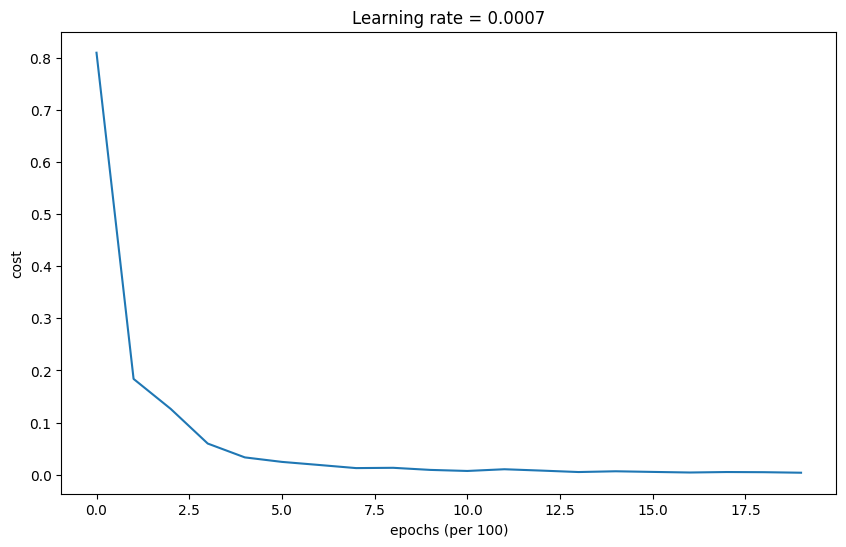

In [25]:
# 训练 3-layer 神经网络
layers_dims = [X_train.shape[0], 20, 10, 1]
parameters = model(X_train, y_train, layers_dims, optimizer = "gd")

In [47]:
'''计算训练样本的准确率'''
predictions = predict(X_train, y_train, parameters)

TypeError: 'numpy.ndarray' object is not callable

In [48]:
'''计算测试样本的准确率'''
predict = predict(X_test, y_test, parameters)

TypeError: 'numpy.ndarray' object is not callable

### 使用 L2 正则化，Adam 优化

In [102]:
# 训练 3-layer 神经网络
layers_dims = [X_train.shape[0], 20, 10, 1]
parameters = model(X_train, y_train, layers_dims, optimizer = "adam",lambd = 0.01)

Cost after epoch 0: 0.831555


f:\python_install\python3.7.9_install\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
f:\python_install\python3.7.9_install\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


Cost after epoch 200: nan
Cost after epoch 400: 0.009810
Cost after epoch 600: 0.006308


KeyboardInterrupt: 

In [46]:
'''训练样本准确率'''
predictions = predict(X_train, y_train, parameters)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
'''测试样本准确率'''
